In [ ]:
import sys
# !{sys.executable} -m pip install tldextract

<div style='text-align:center;'>
<h1>HopRank</h1>
<h2>Empirical Analysis</h2>
</div>

In [1]:
__author__ = "Lisette Espin-Noboa"
__copyright__ = "Copyright 2018, HopRank"
__credits__ = ["Florian Lemmerich", "Markus Strohmaier", "Simon Walk", "Mark Musen"]
__license__ = "GPL"
__version__ = "1.0.3"
__maintainer__ = "Lisette Espin-Noboa"
__email__ = "Lisette.Espin@gesis.org"
__status__ = "Developing"

########################################################################################
# Warnings
########################################################################################
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

<h2>Dependencies</h2>

In [2]:
########################################################################################
# System
########################################################################################
import os
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from collections import Counter
from joblib import Parallel, delayed
import matplotlib as mpl
import matplotlib.pyplot as plt 
from collections import defaultdict

########################################################################################
# Local Dependencies
########################################################################################
%reload_ext autoreload
%autoreload 2
from org.gesis.libs.bioportal.ontology import Ontology
from org.gesis.libs.bioportal.transition import Transition
from org.gesis.libs.bioportal.clickstream import NAVITYPES
from org.gesis.libs.bioportal.clickstream import load_clickstream
from org.gesis.libs.bioportal.clickstream import preprocess_clickstream
from org.gesis.libs.bioportal.clickstream import preprocess_sessions
from org.gesis.libs.bioportal.clickstream import clean_clickstream
from org.gesis.libs.bioportal.submission import get_submissions
from org.gesis.libs.utils import log
from org.gesis.libs.utils import weighted_to_undirected
from org.gesis.libs.utils import to_symmetric

########################################################################################
# Plot's style
########################################################################################
sns.set_context(context="paper", font_scale=1.5)
sns.set_style("whitegrid")

<h2>Constants</h2>

In [3]:
SM = 'submission'
SUBMISSIONS_FN = '/bigdata/lespin/datasets/bioportal/submissions.json'

ON = 'ontology'
ONTOLOGY_ROOT = '/bigdata/lespin/datasets/bioportal/ontologies'
ONTOLOGY_GRAPH_OUTPUT = '/bigdata/lespin/bioportal/ontologies/graph'
ONTOLOGY_ADJACENCY_OUTPUT = '/bigdata/lespin/bioportal/ontologies/matrix'
ONTOLOGY_NODES_OUTPUT = '/bigdata/lespin/bioportal/ontologies/nodes'
ONTOLOGY_HOPS_OUTPUT = '/bigdata/lespin/bioportal/ontologies/hops'

CS = 'clickstream'
CS_FN = 'BP_webpage_requests_<YEAR><POSTFIX>.csv.bz2'
CLICKSTREAM_ROOT = '/bigdata/lespin/datasets/bioportal/clickstream/'
CLICKSTREAM_DF = '/bigdata/lespin/bioportal/clickstreams'

TR = 'transitions'
TRANS_GRAPH_OUTPUT = '/bigdata/lespin/bioportal/transitions/graph'
TRANS_ADJACENCY_OUTPUT = '/bigdata/lespin/bioportal/transitions/matrix'
TRANS_NODES_OUTPUT = '/bigdata/lespin/bioportal/transitions/nodes'
LCC_TRANS_GRAPH_OUTPUT = '/bigdata/lespin/bioportal/transitions_in_lcc/graph'
LCC_TRANS_ADJACENCY_OUTPUT = '/bigdata/lespin/bioportal/transitions_in_lcc/matrix'
LCC_TRANS_NODES_OUTPUT = '/bigdata/lespin/bioportal/transitions_in_lcc/nodes'

SU = 'summary'
LOG_OUTPUT = '/bigdata/lespin/bioportal/logs'
PLOTS_OUTPUT = '/bigdata/lespin/bioportal/plots'
SUMMARY_OUTPUT = '/bigdata/lespin/bioportal/summary'
YEAR = '2015'

LAG_BREAK_IN_MINUTES = 60
MIN_SESSION_LENGTH = 2
MIN_REQ = 1000
MIN_TRANSITIONS = 1000
MAXKHOPS = 32

LCC = True

<div style='text-align:center;'>
<h1>Functions</h1>
</div>

In [40]:
def plot_by(data, x, y, hue, hue_order, height, width, legend_top, legend_ncol, legend_box, palette, xlog, ylog, grid, fn):

    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8, 
                            'xtick.color': 'black', 'ytick.color': 'black',
                           'axes.edgecolor': 'black'})
    
    fg = sns.catplot(data=data,
                 kind='point',
                 x=x,
                 y=y,
                 hue=hue,
                 hue_order=hue_order,
                 height=height,
                 aspect=width/height,
                 legend=not legend_top,
                 legend_out=not legend_top,
                 palette=sns.color_palette(palette, data[hue].nunique()),
                )
    
    if xlog: fg.ax.set_xscale('log')
    if ylog: fg.ax.set_yscale('log')
        
    if legend_top:
        _ = fg.ax.legend(frameon=False, 
                         fancybox=False,
                         bbox_to_anchor=legend_box, 
                         loc="lower left", 
                         ncol=legend_ncol, 
                         mode="expand", 
                         borderaxespad=0)
    
#     plt.xticks(list(plt.xticks()[0]))
    
    fg.ax.grid(grid)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.tight_layout()
    if fn is not None:
        plt.savefig(fn, bbox_inches='tight')

<div style='text-align:center;'>
<h1>Overlaps</h1>
</div>

In [5]:
print('loading submissions...')
submissions_dict = get_submissions(SUBMISSIONS_FN)

print('loading ontologies...')
fn = os.path.join(SUMMARY_OUTPUT,'lcc_summary_ontologies_transitions_{}.{}'.format(YEAR,'csv'))
df_onto = pd.read_csv(fn, index_col=False)
tmp = df_onto.loc[df_onto["T'"] >= MIN_TRANSITIONS].copy()
ontology_order = df_onto.ontology.unique()
del(df_onto)

print('generating k-hop overlaps...')
columns = ['ontology','diameter','navitype','khop','coverage','transitions','%coverage','%transitions','dyads_in_khop','total_transitions_ontology_navitype']
df_overlap = pd.DataFrame(columns=columns)

fn = os.path.join(SUMMARY_OUTPUT,'lcc_summary_overlaps_{}.{}'.format(YEAR,'csv'))
if os.path.exists(fn):
    print('loading summary overlaps...')
    df_overlap = pd.read_csv(fn, index_col=None)
    
for index,row in tmp.iterrows():
    onto_name = row['ontology']
     
    if onto_name in ['SNOMEDCT']:
        continue
        
    if df_overlap.query("ontology == @onto_name").size > 0:
        print("{} already loaded.".format(onto_name))
        continue
        
    submission = submissions_dict[onto_name][YEAR]
    onto = Ontology(name=onto_name, year=YEAR, submission_id=submission['submissionId'], root_folder=ONTOLOGY_ROOT)
    
    for khop in np.arange(1,MAXKHOPS+1,1):    
        
        if khop > row["d'"]:
            continue
          
        try:
            M = onto.get_khop_matrix(path=ONTOLOGY_HOPS_OUTPUT, k=khop, lcc=LCC)
        except:
            continue
        
        try:
            for navitype in [None]+NAVITYPES:            
                # all transitions
                cs = Transition(onto_name, navitype, YEAR)            
                cs.load_adjacency(path=LCC_TRANS_ADJACENCY_OUTPUT)        
                
                if cs.T is not None:
                    total_dydas_in_khop = M.sum()
                    total_transitions = cs.get_undirected_adjacency().sum()
                    coverage_in_khop = M.multiply(cs.get_undirected_adjacency() > 0)
                    transitions_in_khop = M.multiply(cs.get_undirected_adjacency())
                    
                    df_overlap = df_overlap.append({'ontology':onto_name,
                                                    'diameter':row["d'"],
                                                    'navitype':'ALL' if navitype is None else navitype,
                                                    'khop':khop,
                                                    'coverage':coverage_in_khop.sum() / 2.,
                                                    'transitions':transitions_in_khop.sum() / 2.,
                                                    '%coverage':100*coverage_in_khop.sum() / total_dydas_in_khop,
                                                    '%transitions':100*transitions_in_khop.sum() / total_transitions,
                                                    'dyads_in_khop':total_dydas_in_khop,
                                                    'total_transitions_ontology_navitype':total_transitions,
                                                   }
                                                   , ignore_index=True)
                del(cs)
                del(coverage_in_khop)
                del(transitions_in_khop)
            del(M)
        except Exception as ex:
            print(ex)
            df_overlap = df_overlap.append({'ontology':onto_name,
                                            'diameter':row["d'"],
                                            'navitype':'ALL' if navitype is None else navitype,
                                            'khop':khop,
                                            'coverage':0,
                                            'transitions':0,
                                            '%coverage':0.0,
                                            '%transitions':0.0,
                                            'dyads_in_khop':0,
                                            'total_transitions_ontology_navitype':0,
                                           }
                                           , ignore_index=True)

df_overlap.to_csv(fn, index=False)


loading submissions...
2019-02-25 10:47:18	/bigdata/lespin/datasets/bioportal/submissions.json loaded!
2019-02-25 10:47:18	- 642 ontologies
2019-02-25 10:47:18	- 13 years
loading ontologies...
generating k-hop overlaps...
loading summary overlaps...
CPT already loaded.
MEDDRA already loaded.
NDFRT already loaded.
LOINC already loaded.
ICD9CM already loaded.
WHO-ART already loaded.
MESH already loaded.
ICD10 already loaded.
CHMO already loaded.
HL7 already loaded.
OMIM already loaded.


In [6]:
df_overlap.head()

,ontology,diameter,navitype,khop,coverage,transitions,%coverage,%transitions,dyads_in_khop,total_transitions_ontology_navitype
0,CPT,15,ALL,1,3565.0,7763.0,27.192982,17.385949,26220,89302.0
1,CPT,15,DC,1,1108.0,1383.0,8.451564,26.307780,26220,10514.0
2,CPT,15,DE,1,1927.0,2736.0,14.698703,26.214429,26220,20874.0
3,CPT,15,EX,1,1267.0,3374.0,9.664378,28.187135,26220,23940.0
4,CPT,15,DU,1,71.0,77.0,0.541571,1.952333,26220,7888.0


In [ ]:
pd.options.display.max_rows = 999
#print(df_overlap.query("navitype!='ALL'").groupby(['navitype','khop'])['%transitions'].mean())
# df_overlap.groupby(['khop'])['%transitions'].mean().reset_index().sort_values(['%transitions'],ascending=False).round(2)
df_overlap.groupby(['navitype','khop'])['%transitions'].mean().reset_index().sort_values(['navitype','%transitions','khop'],ascending=False).round(2)
# df_overlap.ontology.nunique()
# df_overlap.query('transitions>0').groupby('navitype')['khop'].max().reset_index().khop.mean()
    
    
    

<h2>k-hop Overlap</h2>

In [ ]:
### SORTED BY # TRANSITIONS in LCC

fn = os.path.join(SUMMARY_OUTPUT,'lcc_summary_ontologies_transitions_{}.{}'.format(YEAR,'csv'))
df_onto = pd.read_csv(fn, index_col=False)
tmp = df_onto.loc[df_onto["T'"] >= MIN_TRANSITIONS].copy()
ontology_order = df_onto.sort_values("T'", ascending=False).ontology.unique()

intersect = np.intersect1d(ontology_order, df_overlap.ontology.unique(), assume_unique=True, return_indices=True)
intersect = np.sort(intersect[1])
ontology_order = ontology_order[intersect]

tmp = df_overlap.query("navitype=='ALL' & coverage > 0").copy()
tmp.sort_values('transitions',ascending=False,inplace=True)
fn = os.path.join(PLOTS_OUTPUT,'lcc_summary_coverage_per_khop_sorted_by_transitions.pdf')
plot_by(tmp, 'khop', '%coverage', 'ontology', ontology_order, 3, 6, True, 4, (-0.09, 1.02, 1.1, 0.2), "RdBu_r", False, True, False, fn)


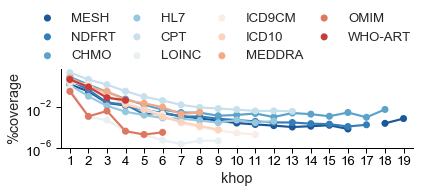

In [39]:
### SORTED BY DIAMETER in LCC

fn = os.path.join(SUMMARY_OUTPUT,'lcc_summary_ontologies_transitions_{}.{}'.format(YEAR,'csv'))
df_onto = pd.read_csv(fn, index_col=False)
tmp = df_onto.loc[df_onto["T'"] >= MIN_TRANSITIONS].copy()
ontology_order = df_onto.sort_values("d'", ascending=False).ontology.unique()

intersect = np.intersect1d(ontology_order, df_overlap.ontology.unique(), assume_unique=True, return_indices=True)
intersect = np.sort(intersect[1])
ontology_order = ontology_order[intersect]

tmp = df_overlap.query("navitype=='ALL' & coverage > 0").copy()
tmp.sort_values('transitions',ascending=False,inplace=True)
fn = os.path.join(PLOTS_OUTPUT,'lcc_summary_coverage_per_khop_sorted_by_diameter.pdf')
plot_by(tmp, 'khop', '%coverage', 'ontology', ontology_order, 2.8, 6, True, 4, (-0.09, 1.02, 1.1, 0.2), "RdBu_r", False, True, False, fn)


In [ ]:
### SORTED BY NODES in LCC

fn = os.path.join(SUMMARY_OUTPUT,'lcc_summary_ontologies_transitions_{}.{}'.format(YEAR,'csv'))
df_onto = pd.read_csv(fn, index_col=False)
tmp = df_onto.loc[df_onto["T'"] >= MIN_TRANSITIONS].copy()
ontology_order = df_onto.sort_values("N'", ascending=False).ontology.unique()

intersect = np.intersect1d(ontology_order, df_overlap.ontology.unique(), assume_unique=True, return_indices=True)
intersect = np.sort(intersect[1])
ontology_order = ontology_order[intersect]

tmp = df_overlap.query("navitype=='ALL' & coverage > 0").copy()
tmp.sort_values('transitions',ascending=False,inplace=True)
fn = os.path.join(PLOTS_OUTPUT,'lcc_summary_coverage_per_khop_sorted_by_nodes.pdf')
plot_by(tmp, 'khop', '%coverage', 'ontology', ontology_order, 3, 6, True, 4, (-0.09, 1.02, 1.1, 0.2), "RdBu_r", False, True, False, fn)


In [ ]:
### SORTED BY EDGES in LCC

fn = os.path.join(SUMMARY_OUTPUT,'lcc_summary_ontologies_transitions_{}.{}'.format(YEAR,'csv'))
df_onto = pd.read_csv(fn, index_col=False)
tmp = df_onto.loc[df_onto["T'"] >= MIN_TRANSITIONS].copy()
ontology_order = df_onto.sort_values("E'", ascending=False).ontology.unique()

intersect = np.intersect1d(ontology_order, df_overlap.ontology.unique(), assume_unique=True, return_indices=True)
intersect = np.sort(intersect[1])
ontology_order = ontology_order[intersect]

tmp = df_overlap.query("navitype=='ALL' & coverage > 0").copy()
tmp.sort_values('transitions',ascending=False,inplace=True)
fn = os.path.join(PLOTS_OUTPUT,'lcc_summary_coverage_per_khop_sorted_by_edges.pdf')
plot_by(tmp, 'khop', '%coverage', 'ontology', ontology_order, 3, 6, True, 4, (-0.09, 1.02, 1.1, 0.2), "RdBu_r", False, True, False, fn)


<h2>Transitions per k-hop</h2>

/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


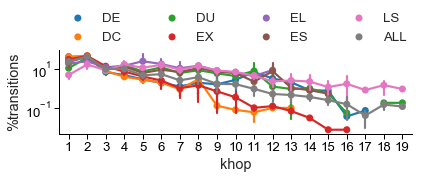

In [37]:
tmp = df_overlap.query("coverage > 0").copy()
navitypes_order = ['DE','DC','DU','EX','EL','ES','LS','ALL']
fn = os.path.join(PLOTS_OUTPUT,'lcc_summary_transitions_per_khop.pdf')
plot_by(tmp, 'khop', '%transitions', 'navitype', navitypes_order, 2.6, 6, True, 4, (0, 1.02, 1, 0.2), None, False, True, False, fn)


<h2>Transitions per ontology and navitype (betas)</h2>

In [ ]:
def  plot_betas(onto_name, df, navitypes_order, fn=None):
    fig, ax = plt.subplots(1, 1, figsize=(5,3))
    cbar_ax = fig.add_axes([.93, .26, .02, .47])

    tmp = df.query("navitype.isin(@navitypes_order)").copy()
    tmp = tmp.pivot(index='navitype', columns='khop', values='%transitions')
    
    tmp.loc[:,0] = 0
    tmp = tmp.reindex(sorted(tmp.columns), axis=1)
    
    tmp = tmp + 1 #0.001
    tmp = tmp.div(tmp.sum(axis=1), axis='index')*100
    tmp.rename(columns={c:r'$\beta{}$'.format(c) for c in tmp.columns}, inplace=True)
    tmp = tmp.reindex(navitypes_order)
      
    ax = sns.heatmap(tmp, 
                     ax = ax,
                     cbar_ax = cbar_ax,
                     cbar = True,
                     cmap = "Blues",
                     square = False)

    _ = ax.set_title(onto_name)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0 if len(tmp.columns) <= 10 else 90)
    _ = ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    _ = ax.set_xlabel('')
    _ = ax.hlines([y-0.03 for y in np.arange(len(navitypes_order))], *ax.get_xlim(), color='white')
    
    if fn is not None:
        plt.savefig(fn, bbox_inches='tight' )
        print('{} saved!'.format(fn))
    plt.show()
    plt.clf()     


In [ ]:
navitypes_order = ['DE','DC','DU','EX','EL','ES','LS','ALL']
tmp = df_overlap.query("khop <= diameter").copy()
for onto_name, df in tmp.groupby('ontology'):
    fn = os.path.join(PLOTS_OUTPUT,'lcc_betas_{}_{}.pdf'.format(onto_name,YEAR))
    _ = plot_betas(onto_name, df, navitypes_order, fn)

In [ ]:
def plot_betas_zero(onto_name, df, navitypes_order, fn=None):
    fig, ax = plt.subplots(1, 1, figsize=(5,3))
    cbar_ax = fig.add_axes([.93, .26, .02, .47])

    tmp = df.query("navitype.isin(@navitypes_order)").copy()
    tmp = tmp.pivot(index='navitype', columns='khop', values='%transitions')

    tmp.loc[:,0] = 0
    tmp = tmp.reindex(sorted(tmp.columns), axis=1)
    
    tmp = tmp + 1
    tmp = tmp.div(tmp.sum(axis=1), axis='index')*100 #row norm
    tmp.rename(columns={c:r'$\beta{}$'.format(c) for c in tmp.columns}, inplace=True)
    tmp = tmp.reindex(navitypes_order)
                
    ax = sns.heatmap(tmp, 
                     ax = ax,
                     cbar_ax = cbar_ax,
                     cbar = True,
                     cmap = "Blues",
                     square = False)

    _ = ax.set_title(onto_name)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0 if len(tmp.columns) <= 10 else 90)
    _ = ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    _ = ax.set_xlabel('')
    _ = ax.hlines([y-0.03 for y in np.arange(len(navitypes_order))], *ax.get_xlim(), color='white')
    
    if fn is not None:
        plt.savefig(fn, bbox_inches='tight' )
        print('{} saved!'.format(fn))
    plt.show()
    plt.clf()     

    
navitypes_order = ['DE','DC','DU','EX','EL','ES','LS','ALL']
tmp = df_overlap.query("khop <= diameter").copy()
for onto_name, df in tmp.groupby('ontology'):

    if onto_name != 'MEDDRA':
        continue
    
    fn = os.path.join(PLOTS_OUTPUT,'lcc_betas_{}_{}.pdf'.format(onto_name,YEAR))
    _ = plot_betas_zero(onto_name, df, navitypes_order, fn)